### Linear mixed effect model to identify associations between clinical data with single-cell cell type abundance phenotypes (CTAPs)

### Fan Zhang

In [1]:
suppressPackageStartupMessages({
library(knitr)
library(ggplot2)
library(mixtools)
library(dplyr)
library(janitor)
library(magrittr)
library(patchwork)
library(readxl)
library(reshape2)
library(MASS)
library(ggrastr)
library(viridis)
library(ggplot2)
library(ggrepel)
require(gdata)
library(stringr)
library(data.table)
library(broom)
library(lme4)
library(preprocessCore)
library(MuMIn)
library(sjstats)
library(ggpubr)
library(cowplot)
})

In [2]:
theme_clean <- function(base_size = 20, base_family = "") {
  theme_classic(
    base_size = base_size, base_family = base_family
  ) %+replace%
    theme(
      #axis.line = element_line(size = 0),
      axis.ticks = element_line(size = 0.2),
      strip.background = element_rect(size = 0),
      panel.background = element_rect(
        size = 0.4, color = "black"
      ),
      axis.line = element_blank()
    )
}

In [3]:
meta_colors = list(

    "cell_type" = c(
        "B cell/plasma cell" = "#FDBF6F",
        "DC" = "#CAB2D6",
        "Fibroblast" = "#08519C",
        "Endothelial cell" = "#A6CEE3",
        "Macrophage" = "#6A3D9A",
        "T cell" = "#B2DF8A",
        "NK" = "#33A02C"
    ),

    "new_class" = c(
        "M" = "#9E0142",
        "T + M" = "#F46D43",
        "T + B" = "#FEE08B",
        "T + F" = "#E6F598",
        "F" = "#ABDDA4",
        "E + F + M" = "#66C2A5"
    )
)

In [39]:
mat <- readRDS("clinical_histo_singlecell_2021-08-28.rds")

ERROR: Error in ggscatter(mat, x = "n_cells", y = "density_overall", add = "reg.line", : could not find function "ggscatter"


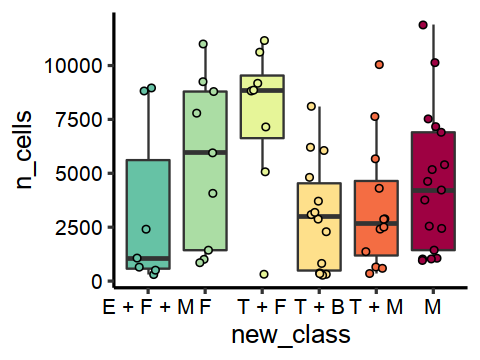

In [40]:
mat$new_class <- factor(mat$new_class, levels = c("E + F + M", "F", "T + F", "T + B", "T + M", "M"))
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(mat,
      aes(x = new_class, y = n_cells, fill = new_class)
      ) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(shape = 21, size = 1.5, stroke = 0.5, width = 0.2) +
    scale_fill_manual("", values = meta_colors$new_class) +
    theme_classic(base_size = 15) +
    theme(
        legend.position = "none",
        #     axis.text = element_blank(),
        #     axis.ticks = element_blank(),
        axis.text.x = element_text(color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid = element_blank()
    )


options(repr.plot.width = 4, repr.plot.height = 3)
ggscatter(mat, x = "n_cells", y = "density_overall",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "black",
                            fill = "lightgray"),
          size = 2, shape = 21, stroke = 0.5, fill = "grey"
          )+
  stat_cor(method = "pearson", size = 4, label.y = 4) +
  theme_classic(base_size = 20) 

In [41]:
mat$n_cells %<>% log2() %>% scale()

In [178]:
response <- "US.PD"
lm1 <- lmer(US.PD ~ 0 + new_class + age + sex + n_cells + (1|site), data = mat, REML = FALSE)
lm0 <- lmer(US.PD ~ 0 + age + sex + n_cells + (1|site), data = mat, REML = FALSE)
anv <- anova(lm0, lm1)

anv$P[2]
r.squaredGLMM(lm1)[1] * 100 - r.squaredGLMM(lm0)[1] * 100

ci <- as.data.frame(confint(lm1, level = 0.95))
ci <- ci[c(3:8),]
colnames(ci) <- c("lower", "upper")

lm1_res = data.frame(
    effect_size = as.numeric(summary(lm1)$coefficients[, 1]),
    p_value = as.numeric(format(sjstats::p_value(lm1), digits = 2)[,2]),
    variable = format(sjstats::p_value(lm1), digits = 2)[,1]
)
lm1_res$neg_log_p <- -log(lm1_res$p_value)
lm1_res <- lm1_res[c(1:6),]
lm1_res$variable <- c("E + F + M", "F", "M", "T + B", "T + F", "T + M")
lm1_res <- cbind(lm1_res, ci)
lm1_res$response <- rep(response, nrow(lm1_res))
lm1_res$anova_p <- rep(anv$P[2], nrow(lm1_res))
lm1_res$var <- rep(r.squaredGLMM(lm1)[1] * 100 - r.squaredGLMM(lm0)[1] * 100, nrow(lm1_res))
lm1_res

saveRDS(lm1_res, paste0("res_lmer_", response, ".rds", sep = ""))

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



[1] 0.3666463

[1] 7.900985

Computing profile confidence intervals ...

Warning message:
“'sjstats::p_value' is deprecated.
Use 'parameters::p_value()' instead.
See help("Deprecated")”
Warning message:
“'sjstats::p_value' is deprecated.
Use 'parameters::p_value()' instead.
See help("Deprecated")”


,effect_size,p_value,variable,neg_log_p,lower,upper,response,anova_p,var
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,0.9954459,0.138,E + F + M,1.980502,-0.38587480,2.332510,US.PD,0.3666463,7.900985
2,1.1080144,0.047,F,3.057608,-0.01917413,2.221193,US.PD,0.3666463,7.900985
3,1.4114967,0.013,M,4.342806,0.27980483,2.543188,US.PD,0.3666463,7.900985
4,0.8201120,0.105,T + B,2.253795,-0.18772697,1.827951,US.PD,0.3666463,7.900985
5,1.0595195,0.030,T + F,3.506558,0.08902633,2.030013,US.PD,0.3666463,7.900985
6,0.5687878,0.284,T + M,1.258781,-0.48884645,1.626105,US.PD,0.3666463,7.900985


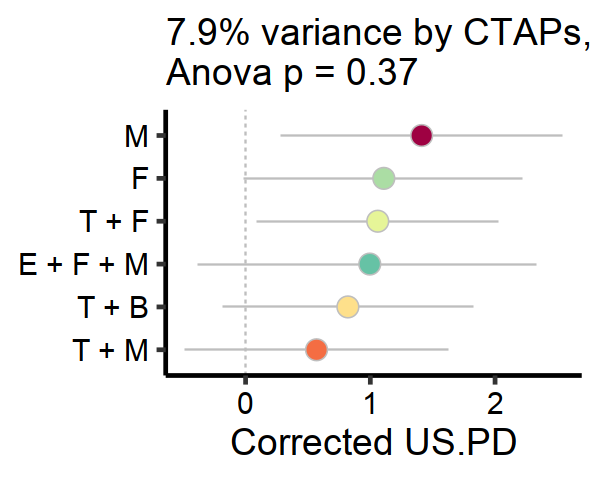

In [179]:
options(repr.plot.width = 5, repr.plot.height = 4)
p1 <- ggplot(lm1_res, aes(x = reorder(variable, effect_size), y=effect_size, ymin=lower, ymax=upper, fill = variable))+
    geom_hline(yintercept = 0, size = 0.5, linetype = "dashed", color = "grey") +
    coord_flip() +
    geom_pointrange(shape = 21, stroke = 0.5, fatten = 11, color = "grey") +
    scale_fill_manual("", values = meta_colors$new_class) +
    labs(y = paste0("Corrected ", response), x = NULL,
         title = paste0(format( (r.squaredGLMM(lm1)[1] - r.squaredGLMM(lm0)[1]) * 100, digits = 2)[1], "% variance by CTAPs,\nAnova p = ", format(anv$P[2], digits=2))) +
    theme_classic(base_size = 22) +
    theme(
        legend.position = "none",
        plot.title = element_text(size=22),
        axis.text.x = element_text(color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid = element_blank() 
    )
p1
# ggsave(file = paste("corrected_", response, "_by_CTAPs", ".pdf", sep = ""), width = 5, height = 4, dpi = 300)

In [203]:
response <- "RA_duration_years.x"
lm1 <- lmer(RA_duration_years.x ~ 0 + new_class + sex + n_cells + (1|site), data = mat, REML = FALSE)
lm0 <- lmer(RA_duration_years.x ~ 0 + sex + n_cells + (1|site), data = mat, REML = FALSE)
anv <- anova(lm0, lm1)

anv$P[2]
r.squaredGLMM(lm1)[1] * 100 - r.squaredGLMM(lm0)[1] * 100

ci <- as.data.frame(confint(lm1, level = 0.95))
ci <- ci[c(3:8),]
colnames(ci) <- c("lower", "upper")

lm1_res = data.frame(
    effect_size = as.numeric(summary(lm1)$coefficients[, 1]),
    p_value = as.numeric(format(sjstats::p_value(lm1), digits = 2)[,2]),
    variable = format(sjstats::p_value(lm1), digits = 2)[,1]
)
lm1_res$neg_log_p <- -log(lm1_res$p_value)
lm1_res <- lm1_res[c(1:6),]
lm1_res$variable <- c("E + F + M", "F", "M", "T + B", "T + F", "T + M")
lm1_res <- cbind(lm1_res, ci)
lm1_res$response <- rep(response, nrow(lm1_res))
lm1_res$anova_p <- rep(anv$P[2], nrow(lm1_res))
lm1_res$var <- rep(r.squaredGLMM(lm1)[1] * 100 - r.squaredGLMM(lm0)[1] * 100, nrow(lm1_res))
lm1_res

saveRDS(lm1_res, paste0("res_lmer_", response, ".rds", sep = ""))

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



[1] 0.1679061

[1] 10.43723

Computing profile confidence intervals ...

Warning message:
“'sjstats::p_value' is deprecated.
Use 'parameters::p_value()' instead.
See help("Deprecated")”
Warning message:
“'sjstats::p_value' is deprecated.
Use 'parameters::p_value()' instead.
See help("Deprecated")”


,effect_size,p_value,variable,neg_log_p,lower,upper,response,anova_p,var
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,13.546385,3.9e-05,E + F + M,10.151949,6.995526,20.097244,RA_duration_years.x,0.1679061,10.43723
2,4.869141,1.0e-01,F,2.302585,-1.017676,10.755961,RA_duration_years.x,0.1679061,10.43723
3,5.082395,1.2e-01,M,2.120264,-1.354727,11.519518,RA_duration_years.x,0.1679061,10.43723
4,8.777318,2.1e-04,T + B,8.468403,4.071033,13.483053,RA_duration_years.x,0.1679061,10.43723
5,3.400010,1.8e-01,T + F,1.714798,-1.669117,8.468671,RA_duration_years.x,0.1679061,10.43723
6,9.055096,5.6e-05,T + M,9.790159,4.585409,13.524818,RA_duration_years.x,0.1679061,10.43723


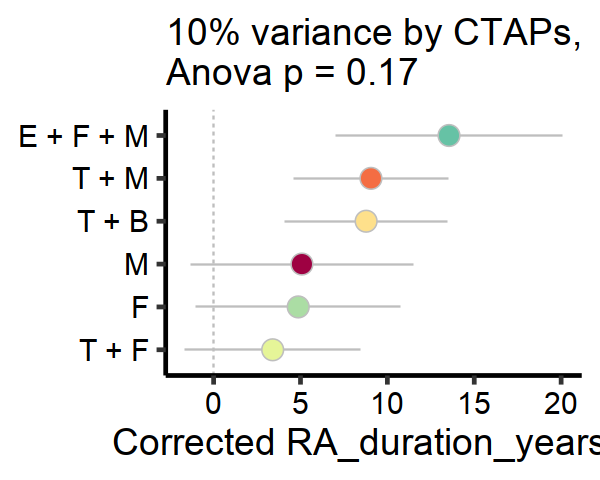

In [204]:
options(repr.plot.width = 5, repr.plot.height = 4)
p14 <- ggplot(lm1_res, aes(x = reorder(variable, effect_size), y=effect_size, ymin=lower, ymax=upper, fill = variable))+
    geom_hline(yintercept = 0, size = 0.5, linetype = "dashed", color = "grey") +
    coord_flip() +
    geom_pointrange(shape = 21, stroke = 0.5, fatten = 11, color = "grey") +
    scale_fill_manual("", values = meta_colors$new_class) +
    labs(y = paste0("Corrected ", response), x = NULL,
         title = paste0(format( (r.squaredGLMM(lm1)[1] - r.squaredGLMM(lm0)[1]) * 100, digits = 2)[1], "% variance by CTAPs,\nAnova p = ", format(anv$P[2], digits=2))) +
    theme_classic(base_size = 22) +
    theme(
        legend.position = "none",
        plot.title = element_text(size=22),
        axis.text.x = element_text(color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid = element_blank() 
    )
p14

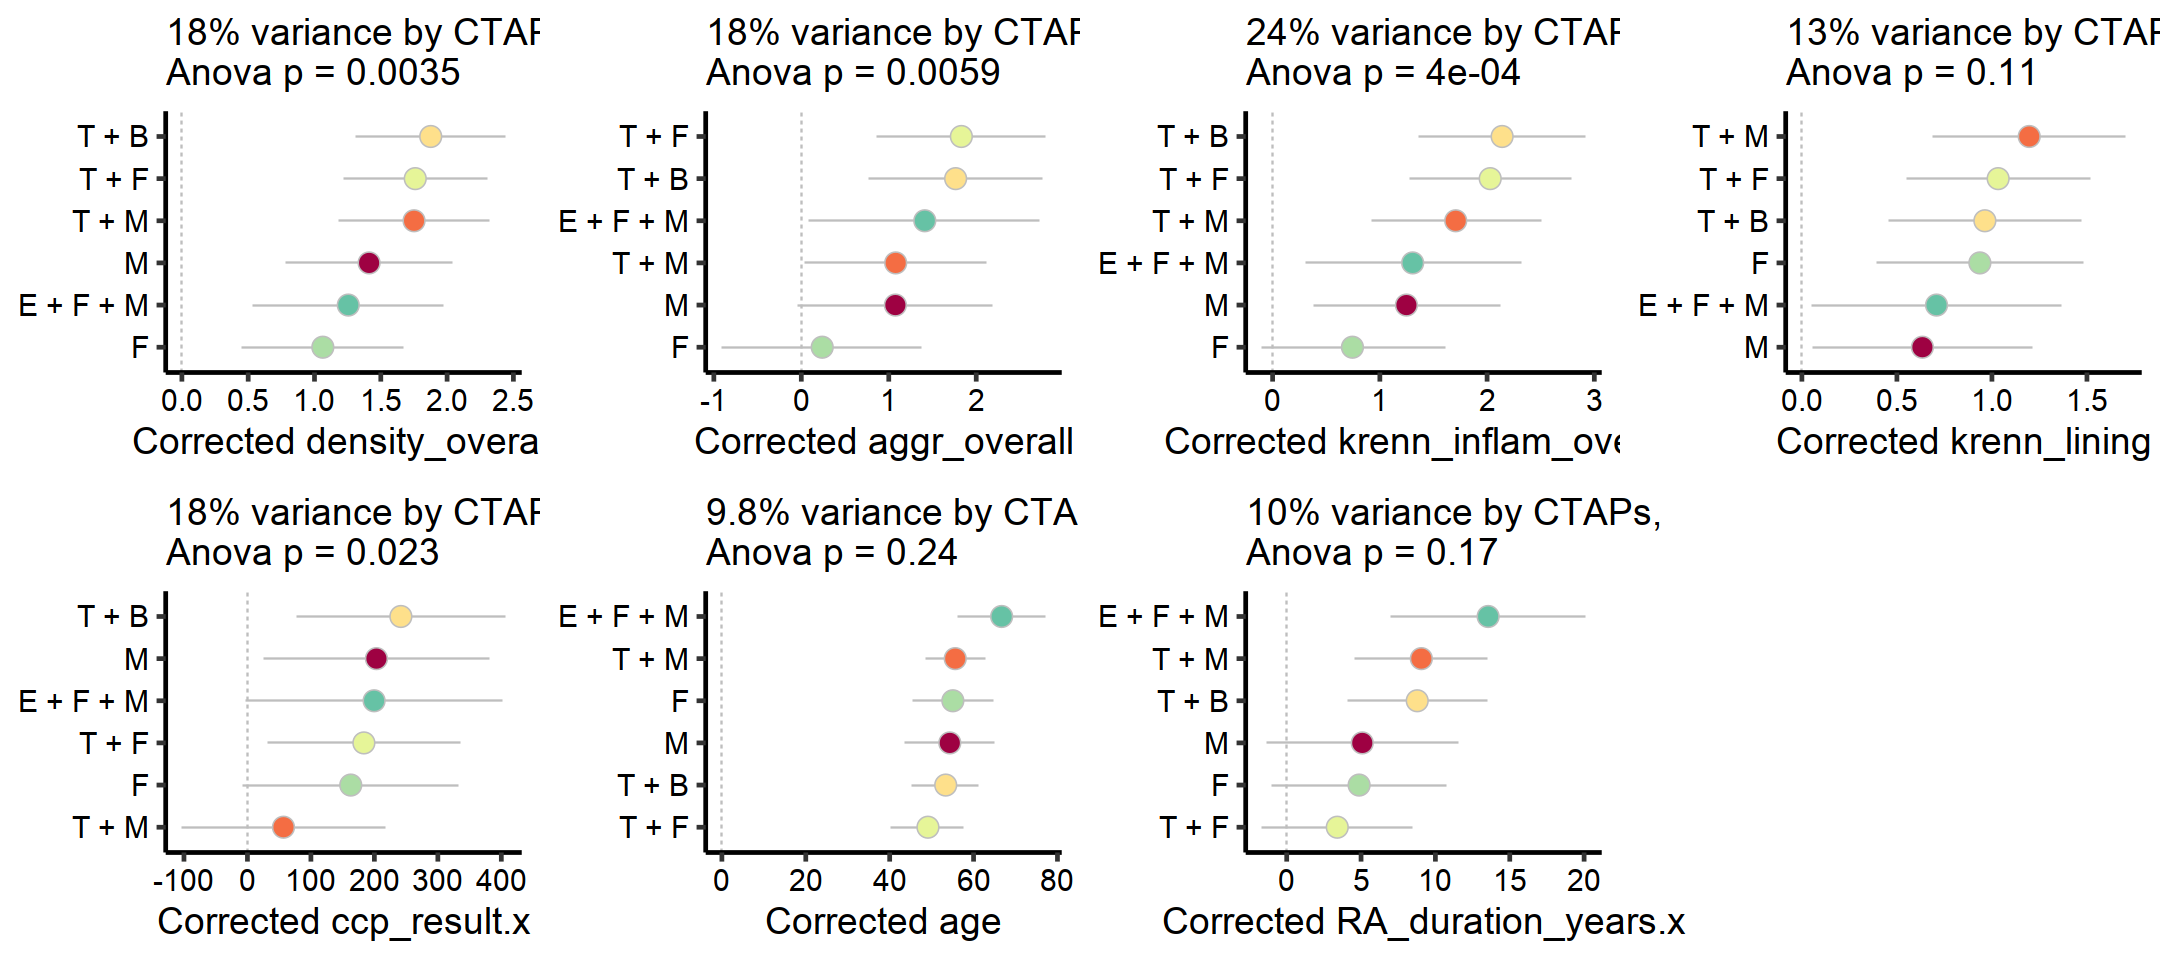

In [215]:
options(repr.plot.width = 18, repr.plot.height = 8)
plot_grid(p5, p6, p7, p8, p4, p13, p14, ncol = 4)
ggsave(file = paste("linear_mixed_model", ".pdf", sep = ""), width = 18, height = 8, dpi = 300)


FALSE  TRUE 
   10     4 

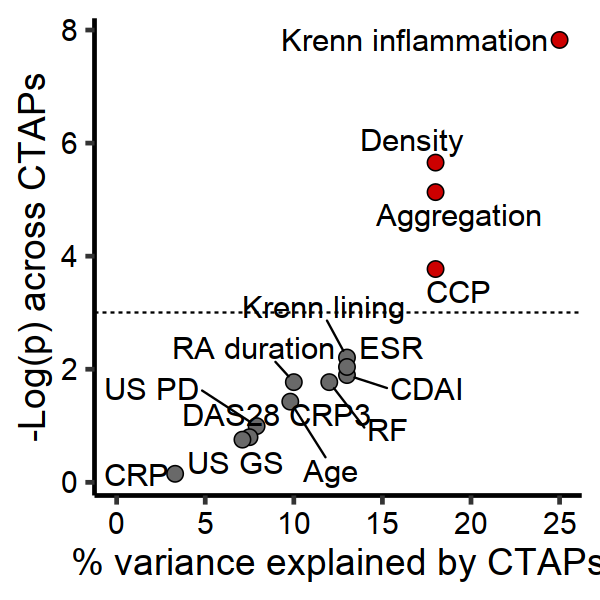

In [214]:
# Add % variance explained together
var = data.frame(
    response = c("Density", "Aggregation", "Krenn inflammation", "Krenn lining", "CCP", "US PD", "US GS", "DAS28 CRP3", "RF", "CDAI", "ESR", "CRP", "Age", "RA duration"),
    perc_variance = c(18, 18, 25, 13, 18, 7.9, 7.1, 7.5, 12, 13, 13, 3.3, 9.8, 10),
    p_value = c(0.0035, 0.0059, 4e-04, 0.11, 0.023, 0.37, 0.47, 0.45, 0.17, 0.15, 0.13, 0.86, 0.24, 0.17)
)
var$logp <- -log(var$p_value)
var$highlight <- var$logp  > -log(0.05)
table(var$highlight)


var <- var[order(var$perc_variance, decreasing = T),]

options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(var, aes(y=perc_variance, x=logp, fill = highlight)) + 
        geom_point(shape = 21, size = 4) +
        coord_flip() +
        geom_vline(xintercept = -log(0.05), linetype = "dashed", size = 0.5) +
#         geom_hline(yintercept = 20, linetype = "dashed", size = 0.5) +
        geom_text_repel(aes(logp, perc_variance, label = response), size = 6.5,
                    box.padding = unit(0.4, "lines"),
                    point.padding = unit(0.5, "lines")
                   ) +
        scale_fill_manual("", values = c("dimgrey", "red3")) +
        scale_y_continuous(limits = c(0, max(var$perc_variance))) +
        labs(x = "-Log(p) across CTAPs", y = "% variance explained by CTAPs") +
        theme_classic(base_size = 22) +
        theme(
            legend.position = "none",
            #     axis.text = element_blank(),
            #     axis.ticks = element_blank(),
            axis.text.x = element_text(color = "black"), #  hjust = 1, angle = 45
            axis.text.y = element_text(color = "black"),
            panel.grid = element_blank()
        )
ggsave(file = paste("perc_variance_all_barplot", ".pdf", sep = ""), width = 5, height = 5, dpi = 300)